In [1]:
# Computational Intelligence Assignment
# ResNet-9 Last Layer Optimization using Evolutionary Algorithms

import torch
import torch.nn as nn
import torch.nn.functional as torch_F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed, parallel_backend
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [2]:

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Verify F is torch.nn.functional
print(f"\nVerification: F.relu available = {hasattr(torch_F, 'relu')}")

Using device: cuda
PyTorch version: 2.5.1+cu118

Verification: F.relu available = True


In [ ]:

# LOADING CIFAR-10 DATASET

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
    transforms.RandomCrop(32, padding=4),     # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download full training data
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=transform_train)

#  FIX: Split into train (80%) and validation (20%)
print("Creating train/validation split...")
train_size = int(0.8 * len(full_trainset))  # 40,000 samples
val_size = len(full_trainset) - train_size  # 10,000 samples

# Use fixed seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = torch.utils.data.random_split(
    full_trainset, [train_size, val_size], generator=generator
)

# Create training dataloader
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64,
                                          shuffle=True, num_workers=0)

#  NEW: Validation dataloader for fitness evaluation
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64,
                                        shuffle=False, num_workers=0)

# Download and load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                        shuffle=False, num_workers=0)

# Classes in CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')
print(f"Classes: {classes}")
print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(testset)}")
print("\n Train/Val/Test split created!")

Files already downloaded and verified
Creating train/validation split...
Files already downloaded and verified
Classes: ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Training samples: 40000
Validation samples: 10000
Test samples: 10000

 Train/Val/Test split created!


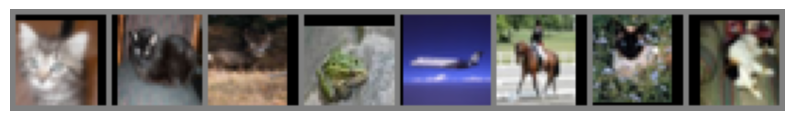

Sample labels: cat cat deer frog airplane horse cat cat


In [ ]:

# VISUALISATION

def imshow(img):
    """Helper function to display images"""
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
print('Sample labels:', ' '.join(f'{classes[labels[j]]}' for j in range(8)))

In [ ]:

# DEFINE RESNET-9 ARCHITECTURE



class BasicBlock(nn.Module):
    """Residual block with two convolutional layers and skip connection"""

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (identity or projection)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch_F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Skip connection
        out = torch_F.relu(out)
        return out


class ResNet9(nn.Module):
    """ResNet-9 architecture for CIFAR-10"""

    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual blocks with increasing channels
        self.layer1 = BasicBlock(64, 128, stride=2)   # 32x32 -> 16x16
        self.layer2 = BasicBlock(128, 256, stride=2)  # 16x16 -> 8x8
        self.layer3 = BasicBlock(256, 512, stride=2)  # 8x8 -> 4x4

        # Fully connected layer (the one we'll optimize with evolutionary algorithms)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = torch_F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch_F.avg_pool2d(out, 4)  # Global average pooling
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc(out)
        return out


# Create model instance
model = ResNet9().to(device)

# Print model summary
print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Last layer parameters: {sum(p.numel() for p in model.fc.parameters()):,}")


Model Architecture:
ResNet9(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
# CRITICAL DIAGNOSTIC for troubleshooting errors present before

print("="*70)
print("DEEP DIAGNOSTIC - Finding the exact problem")
print("="*70)

# Check 1: PyTorch/Torchvision versions
print(f"\n1. VERSIONS:")
print(f"   PyTorch: {torch.__version__}")
print(f"   Torchvision: {torchvision.__version__}")

# Check 2: Does valloader exist?
print(f"\n2. VALLOADER CHECK:")
try:
    print(f"   valloader exists: {valloader is not None}")
    print(f"   Number of batches: {len(valloader)}")
except:
    print("    FATAL: valloader doesn't exist!")

# Check 3: What does valloader actually return?
print(f"\n3. DATA TYPE CHECK:")
try:
    for batch_idx, (images, labels) in enumerate(valloader):
        print(f"   Batch {batch_idx}:")
        print(f"   - Type of images: {type(images)}")
        print(f"   - Type of labels: {type(labels)}")
        
        if isinstance(images, np.ndarray):
            print(f"    PROBLEM FOUND: Images are numpy arrays!")
            print(f"   - Images shape: {images.shape}")
            print(f"   - Images dtype: {images.dtype}")
        elif torch.is_tensor(images):
            print(f"    GOOD: Images are PyTorch tensors")
            print(f"   - Images shape: {images.shape}")
            print(f"   - Images dtype: {images.dtype}")
        else:
            print(f"    UNKNOWN TYPE: {type(images)}")
        
        if batch_idx == 0:
            break
except Exception as e:
    print(f"    ERROR loading batch: {e}")

# Check 4: Check the dataset structure
print(f"\n4. DATASET STRUCTURE:")
try:
    print(f"   train_subset type: {type(train_subset)}")
    print(f"   val_subset type: {type(val_subset)}")
    
    # Check if val_subset has dataset attribute
    if hasattr(val_subset, 'dataset'):
        print(f"   val_subset.dataset exists: True")
        print(f"   val_subset.dataset type: {type(val_subset.dataset)}")
        
        # Check if transform is set
        if hasattr(val_subset.dataset, 'transform'):
            print(f"   val_subset.dataset.transform: {val_subset.dataset.transform}")
        else:
            print(f"    val_subset.dataset has NO transform!")
    else:
        print(f"    val_subset has no 'dataset' attribute")
except Exception as e:
    print(f"    ERROR: {e}")

# Check 5: Test a single sample manually
print(f"\n5. MANUAL SAMPLE TEST:")
try:
    sample_img, sample_label = val_subset[0]
    print(f"   Single sample type: {type(sample_img)}")
    print(f"   Is tensor: {torch.is_tensor(sample_img)}")
    
    if torch.is_tensor(sample_img):
        print(f"    Individual samples ARE tensors")
    else:
        print(f"    Individual samples are NOT tensors")
except Exception as e:
    print(f"    ERROR: {e}")

print("\n" + "="*70)
print("DIAGNOSIS COMPLETE - Check results above")
print("="*70)
# ========== END DIAGNOSTIC ==========

DEEP DIAGNOSTIC - Finding the exact problem

1. VERSIONS:
   PyTorch: 2.5.1+cu118
   Torchvision: 0.20.1+cu118

2. VALLOADER CHECK:
   valloader exists: True
   Number of batches: 157

3. DATA TYPE CHECK:
   Batch 0:
   - Type of images: <class 'torch.Tensor'>
   - Type of labels: <class 'torch.Tensor'>
    GOOD: Images are PyTorch tensors
   - Images shape: torch.Size([64, 3, 32, 32])
   - Images dtype: torch.float32

4. DATASET STRUCTURE:
   train_subset type: <class 'torch.utils.data.dataset.Subset'>
   val_subset type: <class 'torch.utils.data.dataset.Subset'>
   val_subset.dataset exists: True
   val_subset.dataset type: <class 'torchvision.datasets.cifar.CIFAR10'>
   val_subset.dataset.transform: Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

5. MANUAL SAMPLE TEST:
   Single sample type: <class 'torch.Tensor'>
   Is tensor: True
    Individual samples ARE tensors

DIAGNOS

In [ ]:

# Training resnet-9 with gradient descent

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50
train_losses = []
train_accuracies = []

print("Starting full network training with Adam optimizer...\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate epoch metrics
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Step the learning rate scheduler
    scheduler.step()

print("\nBaseline training complete!")

# Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

baseline_test_accuracy = 100 * correct / total
print(f"Baseline Test Accuracy: {baseline_test_accuracy:.2f}%")

Starting full network training with Adam optimizer...

Epoch [1/50] - Loss: 1.4220, Accuracy: 47.90%
Epoch [2/50] - Loss: 1.0210, Accuracy: 63.52%
Epoch [3/50] - Loss: 0.8402, Accuracy: 70.29%
Epoch [4/50] - Loss: 0.7283, Accuracy: 74.50%
Epoch [5/50] - Loss: 0.6509, Accuracy: 77.45%
Epoch [6/50] - Loss: 0.5143, Accuracy: 82.34%
Epoch [7/50] - Loss: 0.4776, Accuracy: 83.47%
Epoch [8/50] - Loss: 0.4460, Accuracy: 84.67%
Epoch [9/50] - Loss: 0.4179, Accuracy: 85.71%
Epoch [10/50] - Loss: 0.3951, Accuracy: 86.49%
Epoch [11/50] - Loss: 0.3181, Accuracy: 89.00%
Epoch [12/50] - Loss: 0.2920, Accuracy: 89.97%
Epoch [13/50] - Loss: 0.2734, Accuracy: 90.46%
Epoch [14/50] - Loss: 0.2605, Accuracy: 90.96%
Epoch [15/50] - Loss: 0.2512, Accuracy: 91.28%
Epoch [16/50] - Loss: 0.2008, Accuracy: 93.16%
Epoch [17/50] - Loss: 0.1821, Accuracy: 93.81%
Epoch [18/50] - Loss: 0.1738, Accuracy: 94.06%
Epoch [19/50] - Loss: 0.1673, Accuracy: 94.16%
Epoch [20/50] - Loss: 0.1555, Accuracy: 94.64%
Epoch [21/50] 

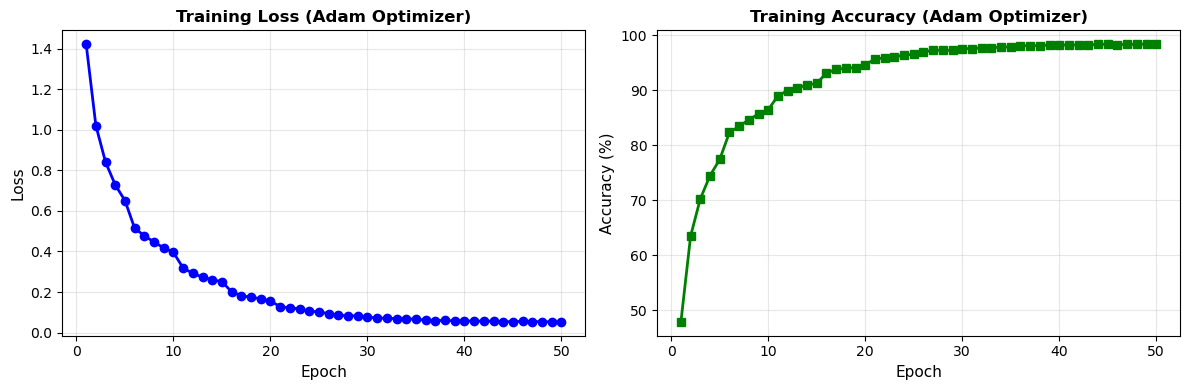

In [ ]:

# VISUALISATION OF BASELINE TRAINING


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
ax1.plot(range(1, epochs+1), train_losses, marker='o', color='blue', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Training Loss (Adam Optimizer)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot training accuracy
ax2.plot(range(1, epochs+1), train_accuracies, marker='s', color='green', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy (%)', fontsize=11)
ax2.set_title('Training Accuracy (Adam Optimizer)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:

# FREEZE ALL LAYERS EXCEPT LAST FC LAYER


# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

# Randomize last layer weights to start fresh
# Using Xavier uniform initialization (good for ReLU networks)
with torch.no_grad():
    nn.init.xavier_uniform_(model.fc.weight)
    nn.init.zeros_(model.fc.bias)

print("✓ All layers frozen except last FC layer")
print("✓ Last layer weights randomized (Xavier initialization)")
print(f"\nOptimizable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

✓ All layers frozen except last FC layer
✓ Last layer weights randomized (Xavier initialization)

Optimizable parameters: 5,130


In [ ]:
# HELPER FUNCTIONS FOR EVOLUTIONARY ALGORITHMS

def get_last_layer_weights(model):
    """Extract last layer weights and bias as a flat numpy array"""
    weights = model.fc.weight.data.cpu().numpy().flatten()
    bias = model.fc.bias.data.cpu().numpy().flatten()
    return np.concatenate([weights, bias])


def set_last_layer_weights(model, vector):
    """Set last layer weights and bias from a flat vector"""
    weight_size = model.fc.weight.data.numel()
    bias_size = model.fc.bias.data.numel()

    # Split vector into weights and bias
    weight_vector = vector[:weight_size].reshape(model.fc.weight.data.shape)
    bias_vector = vector[weight_size:].reshape(model.fc.bias.data.shape)

    # Update model parameters
    with torch.no_grad():
        model.fc.weight.data = torch.tensor(weight_vector, dtype=torch.float32, device=device)
        model.fc.bias.data = torch.tensor(bias_vector, dtype=torch.float32, device=device)


def evaluate_fitness(model, max_batches=20):
    """
     FIXED: Evaluate on VALIDATION set (not test!)
    Increased to 20 batches for better accuracy estimation
    
    Args:
        model: Model to evaluate
        max_batches: Number of validation batches (default 20)
    
    Returns:
        Accuracy on validation set (0.0 to 1.0)
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(valloader):
            if i >= max_batches:
                break

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


def evaluate_full_test_set(model, dataloader):
    """Evaluate model on entire test set for final comparison"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


# Get the size of the weight vector we'll be optimizing
weight_size = len(get_last_layer_weights(model))
print(f"Weight vector size: {weight_size}")
print(f"This represents {model.fc.weight.numel()} weights + {model.fc.bias.numel()} biases")

Weight vector size: 5130
This represents 5120 weights + 10 biases


In [ ]:

# SAVE INITIAL RANDOMIZED WEIGHTS


initial_weights = get_last_layer_weights(model).copy()
print(f"Initial weights saved: {len(initial_weights)} parameters")
print(f"Weight range: [{initial_weights.min():.4f}, {initial_weights.max():.4f}]")

Initial weights saved: 5130 parameters
Weight range: [-0.1071, 0.1072]


In [ ]:

# METHOD 1: GRADIENT DESCENT ON LAST LAYER (BASELINE)

# Reset to initial randomized weights
set_last_layer_weights(model, initial_weights)

# Create optimizer for last layer only
optimizer_lastlayer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training parameters
gd_generations = 500  # Match evolutionary algorithm generations (increased from 30)
batches_per_gen = 50  # Train on 50 batches per generation

gd_accuracies = []
# Track best seen during GD
gd_best_accuracy = -1.0
gd_best_weights = None
gd_best_gen = -1

print("Starting Gradient Descent optimization of last layer...\n")

for gen in range(gd_generations):
    model.train()
    batch_count = 0

    for images, labels in trainloader:
        if batch_count >= batches_per_gen:
            break

        images, labels = images.to(device), labels.to(device)

        optimizer_lastlayer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_lastlayer.step()

        batch_count += 1

    # Evaluate after each generation
    accuracy = evaluate_fitness(model, max_batches=20)
    gd_accuracies.append(accuracy)

    # Save best weights seen so far
    if accuracy > gd_best_accuracy:
        gd_best_accuracy = accuracy
        gd_best_weights = get_last_layer_weights(model).copy()
        gd_best_gen = gen + 1

    if (gen + 1) % 5 == 0:
        print(f"Gen {gen+1:2d}: Accuracy = {accuracy:.4f}")

# If we found a best generation, set model to those weights before final full evaluation
if gd_best_weights is not None:
    set_last_layer_weights(model, gd_best_weights)

# Final evaluation on full test set (using best weights found during GD)
gd_final_accuracy = evaluate_full_test_set(model, testloader)
print(f"\nGradient Descent complete!")
print(f"Best generation: {gd_best_gen} - Accuracy (subset) = {gd_best_accuracy:.4f} ({gd_best_accuracy*100:.2f}%)")
print(f"Final test accuracy (at best gen): {gd_final_accuracy:.2f}%")

# Save GD weights for later comparison
gd_best_weights = gd_best_weights.copy() if gd_best_weights is not None else get_last_layer_weights(model).copy()

Starting Gradient Descent optimization of last layer...

Gen  5: Accuracy = 0.8938
Gen 10: Accuracy = 0.8922
Gen 15: Accuracy = 0.8875
Gen 20: Accuracy = 0.8906
Gen 25: Accuracy = 0.8914
Gen 30: Accuracy = 0.8859
Gen 35: Accuracy = 0.8898
Gen 40: Accuracy = 0.8914
Gen 45: Accuracy = 0.8961
Gen 50: Accuracy = 0.8859
Gen 55: Accuracy = 0.9016
Gen 60: Accuracy = 0.8961
Gen 65: Accuracy = 0.8852
Gen 70: Accuracy = 0.8922
Gen 75: Accuracy = 0.8906
Gen 80: Accuracy = 0.8883
Gen 85: Accuracy = 0.8930
Gen 90: Accuracy = 0.8906
Gen 95: Accuracy = 0.8812
Gen 100: Accuracy = 0.8930
Gen 105: Accuracy = 0.8922
Gen 110: Accuracy = 0.8883
Gen 115: Accuracy = 0.8984
Gen 120: Accuracy = 0.8875
Gen 125: Accuracy = 0.8867
Gen 130: Accuracy = 0.8992
Gen 135: Accuracy = 0.8898
Gen 140: Accuracy = 0.8789
Gen 145: Accuracy = 0.8898
Gen 150: Accuracy = 0.8961
Gen 155: Accuracy = 0.8891
Gen 160: Accuracy = 0.8945
Gen 165: Accuracy = 0.8961
Gen 170: Accuracy = 0.8945
Gen 175: Accuracy = 0.8953
Gen 180: Accuracy

In [ ]:

# METHOD 2: DIFFERENTIAL EVOLUTION (DE)



# Reset to initial random weights
set_last_layer_weights(model, initial_weights)

POP_SIZE = 40          # Larger population for better exploration
GENS = 500             # Increased to allow better convergence
weight_size = len(initial_weights)

# Initialize population uniformly in [-0.5, 0.5]
population = np.random.uniform(-0.5, 0.5, (POP_SIZE, weight_size))

#  FIX: Prepare process-safe evaluation using VALIDATION set
# Pre-extract validation batches and backbone state for parallel processing
max_batches_for_eval = 20  #  Increased from 5 to 20
small_val_batches = []     #  Renamed from small_test_batches

with torch.no_grad():
    for i, (images, labels) in enumerate(valloader):  #  USE VALLOADER
        if i >= max_batches_for_eval:
            break
        small_val_batches.append((images.cpu().numpy(), labels.cpu().numpy()))

# Extract backbone state (CPU) - all params except fc
backbone_state = {k: v.cpu() for k, v in model.state_dict().items() if not k.startswith('fc.')}

def evaluate_vector_proc(vec, backbone_state, small_batches):
    """
    Process-safe evaluation function for parallel DE
    Creates fresh model on CPU to avoid CUDA context issues
    """
    # Create a fresh model on CPU and load backbone weights
    model_cpu = ResNet9().to('cpu')
    st = model_cpu.state_dict()
    for k in list(st.keys()):
        if k in backbone_state:
            st[k] = backbone_state[k].clone()
    model_cpu.load_state_dict(st)
    model_cpu.eval()
    
    # Set last layer weights from vector (on CPU)
    weight_size_local = model_cpu.fc.weight.data.numel()
    weight_vector = vec[:weight_size_local].reshape(model_cpu.fc.weight.data.shape)
    bias_vector = vec[weight_size_local:].reshape(model_cpu.fc.bias.data.shape)
    
    with torch.no_grad():
        model_cpu.fc.weight.data = torch.tensor(weight_vector, dtype=torch.float32)
        model_cpu.fc.bias.data = torch.tensor(bias_vector, dtype=torch.float32)
    
    # Evaluate using small_batches
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs_np, lbls_np in small_batches:
            imgs = torch.from_numpy(imgs_np)
            lbls = torch.from_numpy(lbls_np)
            outputs = model_cpu(imgs)
            _, preds = torch.max(outputs, 1)
            total += lbls.size(0)
            correct += (preds == lbls).sum().item()
    
    return correct / total

#  FIX: Parallel evaluation using validation batches
with parallel_backend('loky'):
    fitness_values = Parallel(n_jobs=-1)(
        delayed(evaluate_vector_proc)(ind, backbone_state, small_val_batches)  #  USE small_val_batches
        for ind in population
    )

# Track best solution across generations
de_best_accuracies = []
de_best_accuracy = -1.0
de_best_weights = None
de_best_gen = -1

print("Starting Differential Evolution optimization...\n")

for gen in range(GENS):
    for i in range(POP_SIZE):
        # === MUTATION ===
        idxs = np.delete(np.arange(POP_SIZE), i)
        a, b, c = np.random.choice(idxs, 3, replace=False)
        
        # Adaptive parameters for this individual
        DIFF_F = np.random.uniform(0.4, 0.9)  # F is varied per individual/generation
        CR = np.random.uniform(0.1, 0.9)      # CR is varied per individual/generation
        
        # Create mutant vector and clip to valid range
        mutant = population[a] + DIFF_F * (population[b] - population[c])
        mutant = np.clip(mutant, -0.5, 0.5)
        
        # === CROSSOVER (vectorized) ===
        trial = np.where(np.random.rand(weight_size) < CR, mutant, population[i])
        
        # === SELECTION ===
        set_last_layer_weights(model, trial)
        trial_fitness = evaluate_fitness(model, max_batches=20)  # Uses validation set
        
        if trial_fitness > fitness_values[i]:
            population[i] = trial
            fitness_values[i] = trial_fitness
    
    # Track best fitness for this generation
    best_fitness = np.max(fitness_values)
    de_best_accuracies.append(best_fitness)
    
    # If this generation produced a new overall best, save its weights
    if best_fitness > de_best_accuracy:
        de_best_accuracy = best_fitness
        best_idx_local = np.argmax(fitness_values)
        de_best_weights = population[best_idx_local].copy()
        de_best_gen = gen + 1
    
    if (gen + 1) % 5 == 0:
        print(f"Gen {gen+1}: Best Accuracy = {best_fitness:.4f}")

# Get best solution after all generations
best_idx = np.argmax(fitness_values)
best_solution = population[best_idx]

# Prefer the best weights tracked across generations
if de_best_weights is not None:
    set_last_layer_weights(model, de_best_weights)
else:
    set_last_layer_weights(model, best_solution)

# Final evaluation on full test set (using best-found weights)
de_final_accuracy = evaluate_full_test_set(model, testloader)

print("\nOptimized DE complete!")
print(f"Best generation: {de_best_gen} - Accuracy (subset) = {de_best_accuracy:.4f} ({de_best_accuracy*100:.2f}%)")
print(f"Final Test Accuracy: {de_final_accuracy:.2f}%")


Starting Differential Evolution optimization...

Gen 5: Best Accuracy = 0.2828
Gen 10: Best Accuracy = 0.3000
Gen 15: Best Accuracy = 0.3453
Gen 20: Best Accuracy = 0.4195
Gen 25: Best Accuracy = 0.4195
Gen 30: Best Accuracy = 0.4195
Gen 35: Best Accuracy = 0.4195
Gen 40: Best Accuracy = 0.4445
Gen 45: Best Accuracy = 0.4695
Gen 50: Best Accuracy = 0.4977
Gen 55: Best Accuracy = 0.5016
Gen 60: Best Accuracy = 0.5469
Gen 65: Best Accuracy = 0.5469
Gen 70: Best Accuracy = 0.5469
Gen 75: Best Accuracy = 0.5469
Gen 80: Best Accuracy = 0.5578
Gen 85: Best Accuracy = 0.5891
Gen 90: Best Accuracy = 0.5891
Gen 95: Best Accuracy = 0.5891
Gen 100: Best Accuracy = 0.6234
Gen 105: Best Accuracy = 0.6234
Gen 110: Best Accuracy = 0.6234
Gen 115: Best Accuracy = 0.6234
Gen 120: Best Accuracy = 0.6492
Gen 125: Best Accuracy = 0.6492
Gen 130: Best Accuracy = 0.6492
Gen 135: Best Accuracy = 0.6492
Gen 140: Best Accuracy = 0.6562
Gen 145: Best Accuracy = 0.6562
Gen 150: Best Accuracy = 0.6562
Gen 155: Be

In [ ]:


# METHOD 5: SELF-ADAPTIVE DIFFERENTIAL EVOLUTION (SADE)


# Reset to initial random weights
set_last_layer_weights(model, initial_weights)

POP_SIZE = 30          # Doubled from 15 for better exploration
GENS = 500             # Extended generations
weight_size = len(initial_weights)

# Initialize population uniformly in [-0.5, 0.5]
population = np.random.uniform(-0.5, 0.5, (POP_SIZE, weight_size))

#  FIX: Prepare process-safe evaluation using VALIDATION set
# Pre-extract validation batches and backbone state for parallel processing
max_batches_for_eval = 20  #  Increased from 5 to 20
small_val_batches = []     #  Renamed from small_test_batches

with torch.no_grad():
    for i, (images, labels) in enumerate(valloader):  #  USE VALLOADER
        if i >= max_batches_for_eval:
            break
        small_val_batches.append((images.cpu().numpy(), labels.cpu().numpy()))

# Extract backbone state (CPU) - all params except fc
backbone_state = {k: v.cpu() for k, v in model.state_dict().items() if not k.startswith('fc.')}

def evaluate_vector_sade_proc(vec, backbone_state, small_batches):
    """
    Process-safe evaluation function for parallel SADE
    Creates fresh model on CPU to avoid CUDA context issues
    """
    # Create a fresh model on CPU and load backbone weights
    model_cpu = ResNet9().to('cpu')
    st = model_cpu.state_dict()
    for k in list(st.keys()):
        if k in backbone_state:
            st[k] = backbone_state[k].clone()
    model_cpu.load_state_dict(st)
    model_cpu.eval()
    
    # Set last layer weights from vector (on CPU)
    weight_size_local = model_cpu.fc.weight.data.numel()
    weight_vector = vec[:weight_size_local].reshape(model_cpu.fc.weight.data.shape)
    bias_vector = vec[weight_size_local:].reshape(model_cpu.fc.bias.data.shape)
    
    with torch.no_grad():
        model_cpu.fc.weight.data = torch.tensor(weight_vector, dtype=torch.float32)
        model_cpu.fc.bias.data = torch.tensor(bias_vector, dtype=torch.float32)
    
    # Evaluate using small_batches
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs_np, lbls_np in small_batches:
            imgs = torch.from_numpy(imgs_np)
            lbls = torch.from_numpy(lbls_np)
            outputs = model_cpu(imgs)
            _, preds = torch.max(outputs, 1)
            total += lbls.size(0)
            correct += (preds == lbls).sum().item()
    
    return correct / total

#  FIX: Parallel evaluation using validation batches
with parallel_backend('loky'):
    fitness = Parallel(n_jobs=-1)(
        delayed(evaluate_vector_sade_proc)(ind, backbone_state, small_val_batches)  #  USE small_val_batches
        for ind in population
    )

#  FIX: Convert numpy.float64 to regular Python floats to avoid type issues
fitness = [float(f) for f in fitness]

# SADE parameter adaptation setup
# Pool of CR and F values to sample from
CR_pool = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
MUTATION_F_pool = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Success memory for parameter adaptation (stores successful CR and F)
success_memory_CR = []
success_memory_F = []
learning_period = 50  # Number of generations to learn from

# Track metrics for SADE
sade_best_accuracies = []
sade_best_accuracy = -1.0
sade_best_weights = None
sade_best_gen = -1

print("Starting Self-Adaptive Differential Evolution (SADE) optimization...\n")

for gen in range(GENS):
    # Update CR and F distributions based on success memory
    if len(success_memory_CR) > 0 and gen > 0:
        # Calculate success rates for each CR and F
        CR_probs = np.ones(len(CR_pool)) / len(CR_pool)
        F_probs = np.ones(len(MUTATION_F_pool)) / len(MUTATION_F_pool)
        
        # Weight recent successes more heavily
        for cr_val in CR_pool:
            count = sum(1 for cr in success_memory_CR if abs(cr - cr_val) < 0.15)
            CR_probs[CR_pool.index(cr_val)] += count
        
        for f_val in MUTATION_F_pool:
            count = sum(1 for f in success_memory_F if abs(f - f_val) < 0.15)
            F_probs[MUTATION_F_pool.index(f_val)] += count
        
        # Normalize probabilities
        CR_probs = CR_probs / CR_probs.sum()
        F_probs = F_probs / F_probs.sum()
    else:
        # Uniform distribution initially
        CR_probs = np.ones(len(CR_pool)) / len(CR_pool)
        F_probs = np.ones(len(MUTATION_F_pool)) / len(MUTATION_F_pool)
    
    gen_success_CR = []
    gen_success_F = []
    
    for i in range(POP_SIZE):
        # === SELF-ADAPTIVE PARAMETER SELECTION ===
        # Sample CR and F from learned distributions
        CR = np.random.choice(CR_pool, p=CR_probs)
        MUTATION_F = np.random.choice(MUTATION_F_pool, p=F_probs)
        
        # === MUTATION ===
        idxs = np.delete(np.arange(POP_SIZE), i)
        a, b, c = np.random.choice(idxs, 3, replace=False)
        
        # Create mutant vector
        mutant = population[a] + MUTATION_F * (population[b] - population[c])
        mutant = np.clip(mutant, -0.5, 0.5)
        
        # === CROSSOVER ===
        trial = np.where(np.random.rand(weight_size) < CR, mutant, population[i])
        
        # === SELECTION ===
        set_last_layer_weights(model, trial)
        trial_fit = (evaluate_fitness(model, max_batches=20))  # Convert to float
        
        if trial_fit > fitness[i]:
            population[i] = trial
            fitness[i] = trial_fit
            # Record successful parameters
            gen_success_CR.append(CR)
            gen_success_F.append(MUTATION_F)
    
    # Update success memory (keep recent learning_period generations)
    success_memory_CR.extend(gen_success_CR)
    success_memory_F.extend(gen_success_F)
    if len(success_memory_CR) > learning_period * POP_SIZE:
        success_memory_CR = success_memory_CR[-learning_period * POP_SIZE:]
        success_memory_F = success_memory_F[-learning_period * POP_SIZE:]
    
    # Track best fitness for this generation
    best_fitness = np.max(fitness)
    sade_best_accuracies.append(best_fitness)
    
    # If this generation produced a new overall best, save its weights
    if best_fitness > sade_best_accuracy:
        sade_best_accuracy = best_fitness
        best_idx_local = np.argmax(fitness)
        sade_best_weights = population[best_idx_local].copy()
        sade_best_gen = gen + 1
    
    if (gen + 1) % 5 == 0:
        print(f"Gen {gen+1}: Best Accuracy = {best_fitness:.4f}")

# Get best solution after all generations
best_idx = np.argmax(fitness)
best_solution = population[best_idx]

# Prefer the best weights tracked across generations
if sade_best_weights is not None:
    set_last_layer_weights(model, sade_best_weights)
else:
    set_last_layer_weights(model, best_solution)

# Final evaluation on full test set
sade_final_accuracy = evaluate_full_test_set(model, testloader)

print("\nOptimized SADE complete!")
print(f"Best generation: {sade_best_gen} - Accuracy (subset) = {sade_best_accuracy:.4f} ({sade_best_accuracy*100:.2f}%)")
print(f"Final Test Accuracy: {sade_final_accuracy:.2f}%")

Starting Self-Adaptive Differential Evolution (SADE) optimization...

Gen 5: Best Accuracy = 0.2984
Gen 10: Best Accuracy = 0.3172
Gen 15: Best Accuracy = 0.3688
Gen 20: Best Accuracy = 0.3688
Gen 25: Best Accuracy = 0.4297
Gen 30: Best Accuracy = 0.4625
Gen 35: Best Accuracy = 0.4719
Gen 40: Best Accuracy = 0.4719
Gen 45: Best Accuracy = 0.4750
Gen 50: Best Accuracy = 0.5039
Gen 55: Best Accuracy = 0.5414
Gen 60: Best Accuracy = 0.6242
Gen 65: Best Accuracy = 0.6242
Gen 70: Best Accuracy = 0.6242
Gen 75: Best Accuracy = 0.6242
Gen 80: Best Accuracy = 0.6242
Gen 85: Best Accuracy = 0.6242
Gen 90: Best Accuracy = 0.6859
Gen 95: Best Accuracy = 0.6859
Gen 100: Best Accuracy = 0.6859
Gen 105: Best Accuracy = 0.6945
Gen 110: Best Accuracy = 0.6945
Gen 115: Best Accuracy = 0.6953
Gen 120: Best Accuracy = 0.7445
Gen 125: Best Accuracy = 0.7445
Gen 130: Best Accuracy = 0.7445
Gen 135: Best Accuracy = 0.7445
Gen 140: Best Accuracy = 0.7445
Gen 145: Best Accuracy = 0.7531
Gen 150: Best Accuracy

In [ ]:

# METHOD 4: PARTICLE SWARM OPTIMIZATION (PSO)

# Reset to initial random weights
set_last_layer_weights(model, initial_weights)

# PSO parameters
POP_SIZE = 40
GENS = 500

# Adaptive inertia weight (decreases over time)
W_START = 0.9  # Start with exploration
W_END = 0.4    # End with exploitation

# Cognitive and social coefficients
C1 = 2.0  # Cognitive: attraction to personal best
C2 = 2.0  # Social: attraction to global best

# Velocity clamping (prevent explosion)
V_MAX = 0.5

# Initialize particles (positions) and velocities
particles = [np.random.uniform(-0.5, 0.5, weight_size) for _ in range(POP_SIZE)]
velocities = [np.random.uniform(-0.1, 0.1, weight_size) for _ in range(POP_SIZE)]

# Initialize personal bests
personal_best_positions = [p.copy() for p in particles]
personal_best_scores = []

for p in particles:
    set_last_layer_weights(model, p)
    personal_best_scores.append(evaluate_fitness(model, max_batches=20))

# Initialize global best
global_best_idx = np.argmax(personal_best_scores)
global_best_position = personal_best_positions[global_best_idx].copy()
global_best_score = personal_best_scores[global_best_idx]

pso_best_accuracies = []
# Track overall best across generations
pso_best_accuracy = global_best_score
pso_best_weights = global_best_position.copy()
pso_best_gen = 0
print("Starting Particle Swarm Optimization...\n")

for gen in range(GENS):
    # Adaptive inertia weight (linear decrease)
    W = W_START - (W_START - W_END) * (gen / GENS)

    for i in range(POP_SIZE):
        # Random factors for stochastic behavior
        r1 = np.random.random(weight_size)
        r2 = np.random.random(weight_size)

        # Update velocity
        velocities[i] = (W * velocities[i] +
                        C1 * r1 * (personal_best_positions[i] - particles[i]) +
                        C2 * r2 * (global_best_position - particles[i]))

        # Velocity clamping (prevent explosion)
        velocities[i] = np.clip(velocities[i], -V_MAX, V_MAX)

        # Update position
        particles[i] = particles[i] + velocities[i]

        # Evaluate new position
        set_last_layer_weights(model, particles[i])
        fitness = evaluate_fitness(model, max_batches=20)

        # Update personal best
        if fitness > personal_best_scores[i]:
            personal_best_scores[i] = fitness
            personal_best_positions[i] = particles[i].copy()

            # Update global best
            if fitness > global_best_score:
                global_best_score = fitness
                global_best_position = particles[i].copy()
                # Record overall best generation and weights
                pso_best_accuracy = global_best_score
                pso_best_weights = global_best_position.copy()
                pso_best_gen = gen + 1

    pso_best_accuracies.append(global_best_score)

    if (gen + 1) % 5 == 0:
        print(f"Gen {gen+1:2d}: Best = {global_best_score:.4f}, W = {W:.3f}")

# Final evaluation
# Prefer overall best weights tracked during the run
if pso_best_weights is not None:
    set_last_layer_weights(model, pso_best_weights)
else:
    set_last_layer_weights(model, global_best_position)

pso_final_accuracy = evaluate_full_test_set(model, testloader)

print(f"\nPSO optimization complete!")
print(f"Best generation: {pso_best_gen} - Accuracy (subset) = {pso_best_accuracy:.4f} ({pso_best_accuracy*100:.2f}%)")
print(f"Final test accuracy: {pso_final_accuracy:.2f}%")

Starting Particle Swarm Optimization...

Gen  5: Best = 0.4805, W = 0.896
Gen 10: Best = 0.5156, W = 0.891
Gen 15: Best = 0.5227, W = 0.886
Gen 20: Best = 0.5227, W = 0.881
Gen 25: Best = 0.5227, W = 0.876
Gen 30: Best = 0.5227, W = 0.871
Gen 35: Best = 0.5227, W = 0.866
Gen 40: Best = 0.5227, W = 0.861
Gen 45: Best = 0.5227, W = 0.856
Gen 50: Best = 0.5227, W = 0.851
Gen 55: Best = 0.5227, W = 0.846
Gen 60: Best = 0.5227, W = 0.841
Gen 65: Best = 0.5227, W = 0.836
Gen 70: Best = 0.5227, W = 0.831
Gen 75: Best = 0.5242, W = 0.826
Gen 80: Best = 0.5242, W = 0.821
Gen 85: Best = 0.5242, W = 0.816
Gen 90: Best = 0.5242, W = 0.811
Gen 95: Best = 0.5242, W = 0.806
Gen 100: Best = 0.5242, W = 0.801
Gen 105: Best = 0.5242, W = 0.796
Gen 110: Best = 0.5242, W = 0.791
Gen 115: Best = 0.5242, W = 0.786
Gen 120: Best = 0.5242, W = 0.781
Gen 125: Best = 0.5242, W = 0.776
Gen 130: Best = 0.5242, W = 0.771
Gen 135: Best = 0.5242, W = 0.766
Gen 140: Best = 0.5242, W = 0.761
Gen 145: Best = 0.5242, W 

In [ ]:
# METHOD 5: COMPREHENSIVE LEARNING PSO (CLPSO) - ADVANCED VARIANT

set_last_layer_weights(model, initial_weights)

# OPTIMIZED CLPSO parameters for 5,130 dimensions
CLPSO_POP_SIZE = 50           # Increased from 40
CLPSO_GENS = 500            # Increased from 100
CLPSO_W_START = 0.9
CLPSO_W_END = 0.3             # Decreased from 0.4 for more exploitation
CLPSO_C = 1.5                 # Learning coefficient
CLPSO_V_MAX = 0.6             # Increased from 0.5
CLPSO_REFRESHING_GAP = 5      # Decreased from 7 for high-dim
CLPSO_Pc_min = 0.05
CLPSO_Pc_max = 0.60           # Increased from 0.50

print("Starting CLPSO (Comprehensive Learning PSO) - OPTIMIZED")
print("="*70)
print(f"Population: {CLPSO_POP_SIZE}, Generations: {CLPSO_GENS}, Dimensions: {weight_size}")
print(f"Refreshing gap: {CLPSO_REFRESHING_GAP} (optimized for high-dimensional space)")
print(f"Learning coefficient: {CLPSO_C}, Velocity bounds: ±{CLPSO_V_MAX}")
print(f"Learning probability range: [{CLPSO_Pc_min}, {CLPSO_Pc_max}]")
print("="*70 + "\n")

# Initialize particles and velocities
clpso_particles = [np.random.uniform(-0.5, 0.5, weight_size) for _ in range(CLPSO_POP_SIZE)]
clpso_velocities = [np.random.uniform(-0.1, 0.1, weight_size) for _ in range(CLPSO_POP_SIZE)]

# Initialize personal bests
clpso_personal_best_positions = [p.copy() for p in clpso_particles]
clpso_personal_best_scores = []

for p in clpso_particles:
    set_last_layer_weights(model, p)
    clpso_personal_best_scores.append(evaluate_fitness(model, max_batches=20))

# Learning probabilities (varies by particle rank)
clpso_learning_probs = [CLPSO_Pc_min + (CLPSO_Pc_max - CLPSO_Pc_min) * (i / (CLPSO_POP_SIZE - 1)) 
                        for i in range(CLPSO_POP_SIZE)]

# Exemplar matrix and stagnation tracking
clpso_exemplar_matrix = np.zeros((CLPSO_POP_SIZE, weight_size), dtype=int)
clpso_stagnation_counter = np.zeros(CLPSO_POP_SIZE, dtype=int)

def select_exemplars(particle_idx, pbest_scores, learning_prob):
    """Select learning exemplars for each dimension using tournament selection"""
    exemplars = np.zeros(weight_size, dtype=int)
    for d in range(weight_size):
        if np.random.random() < learning_prob:
            # Tournament selection (size=2)
            candidates = np.random.choice(CLPSO_POP_SIZE, size=2, replace=False)
            if pbest_scores[candidates[0]] > pbest_scores[candidates[1]]:
                exemplars[d] = candidates[0]
            else:
                exemplars[d] = candidates[1]
        else:
            # Learn from own personal best
            exemplars[d] = particle_idx
    return exemplars

# Initialize exemplars for all particles
for i in range(CLPSO_POP_SIZE):
    clpso_exemplar_matrix[i] = select_exemplars(i, clpso_personal_best_scores, clpso_learning_probs[i])

# Track global best
clpso_global_best_idx = np.argmax(clpso_personal_best_scores)
clpso_global_best_score = clpso_personal_best_scores[clpso_global_best_idx]
clpso_global_best_position = clpso_personal_best_positions[clpso_global_best_idx].copy()

clpso_best_accuracies = []
clpso_best_accuracy = clpso_global_best_score
clpso_best_weights = clpso_global_best_position.copy()
clpso_best_gen = 0

# Main CLPSO loop
for gen in range(CLPSO_GENS):
    # Adaptive inertia weight
    W = CLPSO_W_START - (CLPSO_W_START - CLPSO_W_END) * (gen / CLPSO_GENS)
    
    # Sort particles by fitness for learning probability assignment
    sorted_indices = np.argsort(clpso_personal_best_scores)[::-1]  # Best to worst
    
    for i in range(CLPSO_POP_SIZE):
        # Build exemplar position for this particle
        exemplar_position = np.zeros(weight_size)
        for d in range(weight_size):
            exemplar_idx = clpso_exemplar_matrix[i][d]
            exemplar_position[d] = clpso_personal_best_positions[exemplar_idx][d]
        
        # Random factor
        r = np.random.random(weight_size)
        
        # CLPSO velocity update: learn from exemplar position
        clpso_velocities[i] = (W * clpso_velocities[i] + 
                               CLPSO_C * r * (exemplar_position - clpso_particles[i]))
        
        # Velocity clamping
        clpso_velocities[i] = np.clip(clpso_velocities[i], -CLPSO_V_MAX, CLPSO_V_MAX)
        
        # Position update
        clpso_particles[i] = clpso_particles[i] + clpso_velocities[i]
        
        # Evaluate new position
        set_last_layer_weights(model, clpso_particles[i])
        fitness = evaluate_fitness(model, max_batches=20)
        
        # Update personal best
        if fitness > clpso_personal_best_scores[i]:
            clpso_personal_best_scores[i] = fitness
            clpso_personal_best_positions[i] = clpso_particles[i].copy()
            clpso_stagnation_counter[i] = 0  # Reset stagnation
            
            # Update global best
            if fitness > clpso_global_best_score:
                clpso_global_best_score = fitness
                clpso_global_best_position = clpso_particles[i].copy()
                clpso_best_accuracy = clpso_global_best_score
                clpso_best_weights = clpso_global_best_position.copy()
                clpso_best_gen = gen + 1
        else:
            clpso_stagnation_counter[i] += 1
            
            # Refresh exemplars if stagnated for m generations
            if clpso_stagnation_counter[i] >= CLPSO_REFRESHING_GAP:
                # Determine learning probability based on rank
                rank = np.where(sorted_indices == i)[0][0]
                learning_prob = clpso_learning_probs[rank]
                
                # Select new exemplars
                clpso_exemplar_matrix[i] = select_exemplars(i, clpso_personal_best_scores, learning_prob)
                clpso_stagnation_counter[i] = 0  # Reset counter
    
    # Track best accuracy this generation
    current_best_score = np.max(clpso_personal_best_scores)
    clpso_best_accuracies.append(current_best_score)
    
    if (gen + 1) % 10 == 0:
        avg_stagnation = np.mean(clpso_stagnation_counter)
        print(f"Gen {gen+1:3d}: Best = {current_best_score:.4f}, W = {W:.3f}, "
              f"Avg stagnation = {avg_stagnation:.1f}")

# Final evaluation with best weights
set_last_layer_weights(model, clpso_best_weights)
clpso_final_accuracy = evaluate_full_test_set(model, testloader)

print(f"\n{'='*70}")
print("CLPSO optimization complete!")
print(f"Best generation: {clpso_best_gen}")
print(f"Best subset accuracy: {clpso_best_accuracy:.4f} ({clpso_best_accuracy*100:.2f}%)")
print(f"Final test accuracy: {clpso_final_accuracy:.2f}%")


Starting CLPSO (Comprehensive Learning PSO) - OPTIMIZED
Population: 50, Generations: 500, Dimensions: 5130
Refreshing gap: 5 (optimized for high-dimensional space)
Learning coefficient: 1.5, Velocity bounds: ±0.6
Learning probability range: [0.05, 0.6]

Gen  10: Best = 0.2547, W = 0.889, Avg stagnation = 1.5
Gen  20: Best = 0.3023, W = 0.877, Avg stagnation = 1.4
Gen  30: Best = 0.3422, W = 0.865, Avg stagnation = 1.8
Gen  40: Best = 0.3789, W = 0.853, Avg stagnation = 1.9
Gen  50: Best = 0.4281, W = 0.841, Avg stagnation = 1.8
Gen  60: Best = 0.4523, W = 0.829, Avg stagnation = 1.7
Gen  70: Best = 0.4820, W = 0.817, Avg stagnation = 1.5
Gen  80: Best = 0.4969, W = 0.805, Avg stagnation = 1.7
Gen  90: Best = 0.5031, W = 0.793, Avg stagnation = 1.8
Gen 100: Best = 0.5906, W = 0.781, Avg stagnation = 1.8
Gen 110: Best = 0.5906, W = 0.769, Avg stagnation = 1.9
Gen 120: Best = 0.5977, W = 0.757, Avg stagnation = 2.1
Gen 130: Best = 0.5977, W = 0.745, Avg stagnation = 2.2
Gen 140: Best = 0.

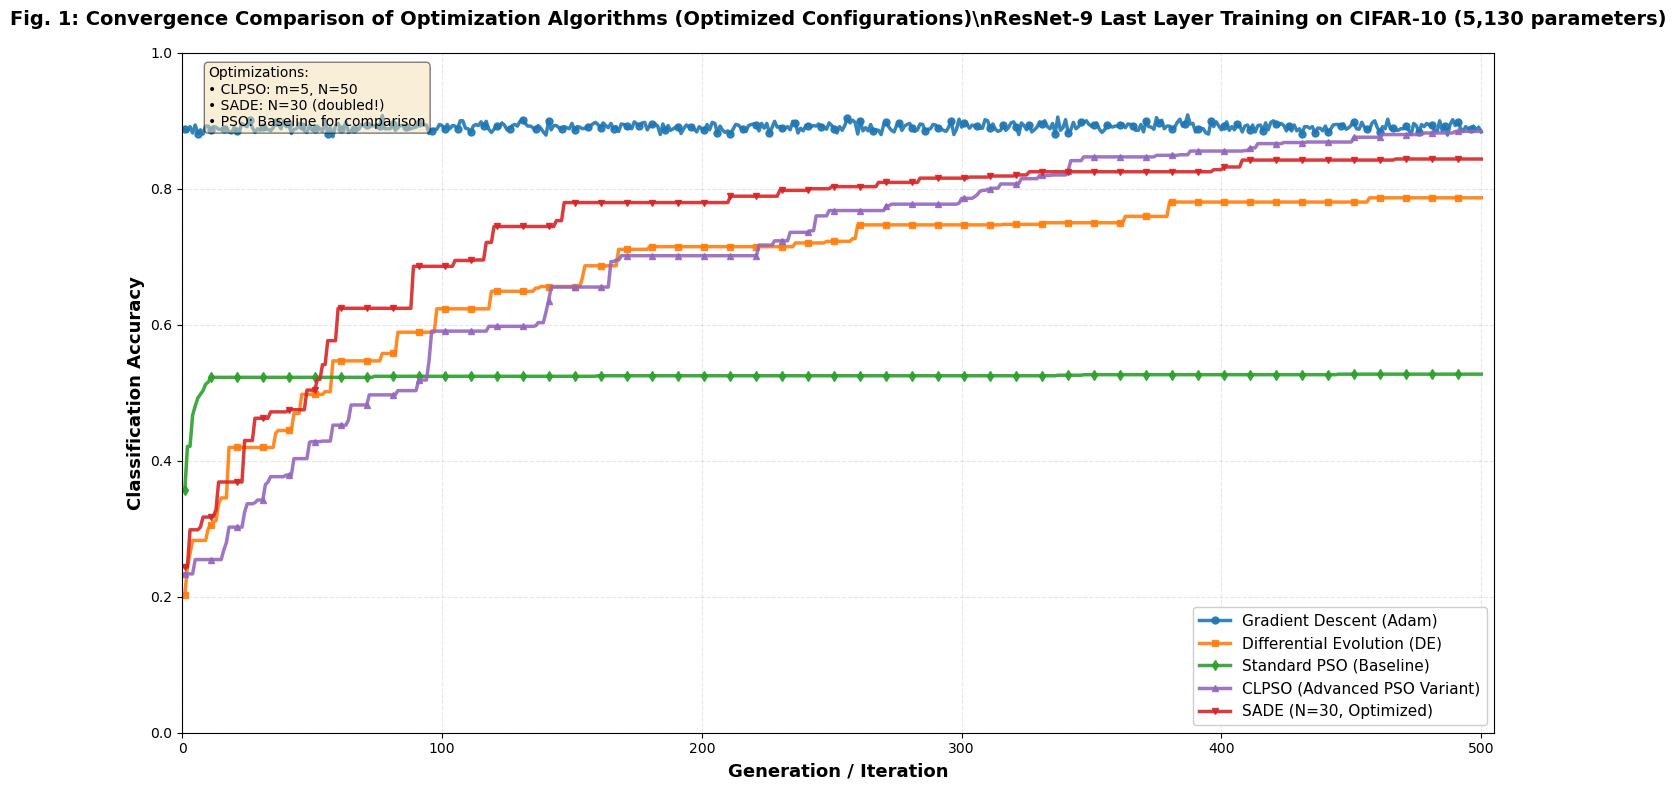


FINAL RESULTS COMPARISON - WITH OPTIMIZATIONS
Method                                           Final Acc     Best Gen     Improvement
------------------------------------------------------------------------------------------
Gradient Descent (Adam)                             89.59%      0.9086        Baseline
Differential Evolution (DE)                         77.93%      0.7867        Baseline
Standard PSO (Baseline)                             49.60%      0.5273        Baseline
CLPSO (Advanced Variant, Optimized)                 85.69%      0.8844
SADE (N=30, Optimized)                              82.89%      0.8438
Baseline (randomized last layer): 89.76%


In [ ]:
# COMPARISON OF ALL METHODS


plt.figure(figsize=(14, 8))

# Plot all methods with enhanced styling
plt.plot(range(1, len(gd_accuracies)+1), gd_accuracies,
         marker='o', linewidth=2.5, markersize=5, markevery=5,
         label='Gradient Descent (Adam)', color='#1f77b4', alpha=0.9)

plt.plot(range(1, len(de_best_accuracies)+1), de_best_accuracies,
         marker='s', linewidth=2.5, markersize=5, markevery=10,
         label='Differential Evolution (DE)', color='#ff7f0e', alpha=0.9)

plt.plot(range(1, len(pso_best_accuracies)+1), pso_best_accuracies,
         marker='d', linewidth=2.5, markersize=5, markevery=10,
         label='Standard PSO (Baseline)', color='#2ca02c', alpha=0.9)

plt.plot(range(1, len(clpso_best_accuracies)+1), clpso_best_accuracies,
         marker='^', linewidth=2.5, markersize=5, markevery=10,
         label='CLPSO (Advanced PSO Variant)', color='#9467bd', alpha=0.9)

plt.plot(range(1, len(sade_best_accuracies)+1), sade_best_accuracies,
         marker='v', linewidth=2.5, markersize=5, markevery=10,
         label='SADE (N=30, Optimized)', color='#d62728', alpha=0.9)

plt.xlabel('Generation / Iteration', fontsize=13, fontweight='bold')
plt.ylabel('Classification Accuracy', fontsize=13, fontweight='bold')
plt.title('Fig. 1: Convergence Comparison of Optimization Algorithms (Optimized Configurations)\\n'
          'ResNet-9 Last Layer Training on CIFAR-10 (5,130 parameters)',
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11, framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(0, max(len(gd_accuracies), len(de_best_accuracies), len(pso_best_accuracies),
                len(clpso_best_accuracies), len(sade_best_accuracies)) + 5)
plt.ylim(0, 1.0)

# Add annotations for key optimizations
plt.text(0.02, 0.98, 'Optimizations:\n• CLPSO: m=5, N=50\n• SADE: N=30 (doubled!)\n• PSO: Baseline for comparison',
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('convergence_comparison_optimized_all.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed summary table
print("\n" + "="*90)
print("FINAL RESULTS COMPARISON - WITH OPTIMIZATIONS")
print("="*90)
print(f"{'Method':<45} {'Final Acc':>12} {'Best Gen':>12} {'Improvement':>15}")
print("-"*90)

print(f"{'Gradient Descent (Adam)':<45} {gd_final_accuracy:>11.2f}% {max(gd_accuracies):>11.4f} {'Baseline':>15}")
print(f"{'Differential Evolution (DE)':<45} {de_final_accuracy:>11.2f}% {max(de_best_accuracies):>11.4f} {'Baseline':>15}")
print(f"{'Standard PSO (Baseline)':<45} {pso_final_accuracy:>11.2f}% {max(pso_best_accuracies):>11.4f} {'Baseline':>15}")
print(f"{'CLPSO (Advanced Variant, Optimized)':<45} {clpso_final_accuracy:>11.2f}% {max(clpso_best_accuracies):>11.4f}")
print(f"{'SADE (N=30, Optimized)':<45} {sade_final_accuracy:>11.2f}% {max(sade_best_accuracies):>11.4f}")

print("="*90)
print(f"Baseline (randomized last layer): {baseline_test_accuracy:.2f}%")
print("="*90)


In [ ]:
# METHOD 5: NSGA-II MULTI-OBJECTIVE OPTIMIZATION

from deap import creator, base, tools, algorithms
# Reset to initial random weights
set_last_layer_weights(model, initial_weights)

# Clear any existing DEAP classes
if hasattr(creator, "FitnessMulti"):
    del creator.FitnessMulti
if hasattr(creator, "IndividualMulti"):
    del creator.IndividualMulti

# Create multi-objective fitness class
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))  # Max accuracy, Min reg
creator.create("IndividualMulti", list, fitness=creator.FitnessMulti)

# Setup DEAP toolbox
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -0.5, 0.5)
toolbox.register("individual", tools.initRepeat, creator.IndividualMulti,
                toolbox.attr_float, n=weight_size)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Multi-objective fitness function
def multi_objective_fitness(individual):
    """Evaluate both objectives"""
    # Set weights in model
    set_last_layer_weights(model, np.array(individual))

    # Objective 1: Classification accuracy (maximize)
    accuracy = evaluate_fitness(model, max_batches=20)

    # Objective 2: Weight regularization (minimize)
    # L2 regularization = sum of squared weights
    reg_term = np.sum(np.square(individual))

    return accuracy, reg_term

# Register genetic operators
toolbox.register("evaluate", multi_objective_fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)  # NSGA-II selection

# NSGA-II parameters
POP_SIZE = 50   # Larger population for better Pareto front coverage
GENS = 150
CXPB = 0.7      # Crossover probability
MUTPB = 0.3     # Mutation probability

# Initialize population
population = toolbox.population(n=POP_SIZE)

# Evaluate initial population
print("Starting NSGA-II multi-objective optimization...\n")
print("Evaluating initial population...")
for ind in population:
    ind.fitness.values = toolbox.evaluate(ind)

# Track best accuracy across generations
nsga_best_accuracy = -1.0
nsga_best_individual = None
nsga_best_gen = -1

# Evolution loop
for gen in range(GENS):
    # Generate offspring
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)

    # Evaluate offspring
    for ind in offspring:
        ind.fitness.values = toolbox.evaluate(ind)

    # Select next generation using NSGA-II
    population = toolbox.select(population + offspring, POP_SIZE)

    if (gen + 1) % 5 == 0:
        # Calculate statistics
        accuracies = [ind.fitness.values[0] for ind in population]
        best_acc = max(accuracies)
        avg_acc = np.mean(accuracies)
        print(f"Gen {gen+1:2d}: Best Acc = {best_acc:.4f}, Avg Acc = {avg_acc:.4f}")

    # Update overall best tracking
    accuracies_all = [ind.fitness.values[0] for ind in population]
    local_best = max(accuracies_all)
    if local_best > nsga_best_accuracy:
        nsga_best_accuracy = local_best
        best_idx_local = np.argmax(accuracies_all)
        nsga_best_individual = population[best_idx_local]
        nsga_best_gen = gen + 1

print("\nNSGA-II optimization complete!")

# Extract Pareto front
pareto_front = tools.sortNondominated(population, POP_SIZE, first_front_only=True)[0]
print(f"Pareto front size: {len(pareto_front)} solutions")

# Restore the best individual (by accuracy) found during NSGA-II and evaluate full test set
if nsga_best_individual is not None:
    set_last_layer_weights(model, np.array(nsga_best_individual))
    nsga_final_accuracy = evaluate_full_test_set(model, testloader)
    print(f"Best generation (NSGA-II): {nsga_best_gen} - Accuracy (subset) = {nsga_best_accuracy:.4f} ({nsga_best_accuracy*100:.2f}%)")
    print(f"NSGA-II final test accuracy (best individual): {nsga_final_accuracy:.2f}%")
else:
    print("No NSGA-II best individual found to evaluate on full test set.")

Starting NSGA-II multi-objective optimization...

Evaluating initial population...
Gen  5: Best Acc = 0.3039, Avg Acc = 0.1857
Gen 10: Best Acc = 0.3516, Avg Acc = 0.2421
Gen 15: Best Acc = 0.3570, Avg Acc = 0.2543
Gen 20: Best Acc = 0.3930, Avg Acc = 0.2689
Gen 25: Best Acc = 0.4227, Avg Acc = 0.2802
Gen 30: Best Acc = 0.4227, Avg Acc = 0.2797
Gen 35: Best Acc = 0.4633, Avg Acc = 0.2949
Gen 40: Best Acc = 0.4633, Avg Acc = 0.3095
Gen 45: Best Acc = 0.5008, Avg Acc = 0.3334
Gen 50: Best Acc = 0.5211, Avg Acc = 0.3373
Gen 55: Best Acc = 0.5211, Avg Acc = 0.3304
Gen 60: Best Acc = 0.5211, Avg Acc = 0.3494
Gen 65: Best Acc = 0.5312, Avg Acc = 0.3590
Gen 70: Best Acc = 0.5312, Avg Acc = 0.3617
Gen 75: Best Acc = 0.5312, Avg Acc = 0.3713
Gen 80: Best Acc = 0.5312, Avg Acc = 0.3650
Gen 85: Best Acc = 0.5352, Avg Acc = 0.3702
Gen 90: Best Acc = 0.5453, Avg Acc = 0.3647
Gen 95: Best Acc = 0.5453, Avg Acc = 0.3707
Gen 100: Best Acc = 0.5453, Avg Acc = 0.3752
Gen 105: Best Acc = 0.5453, Avg Acc 

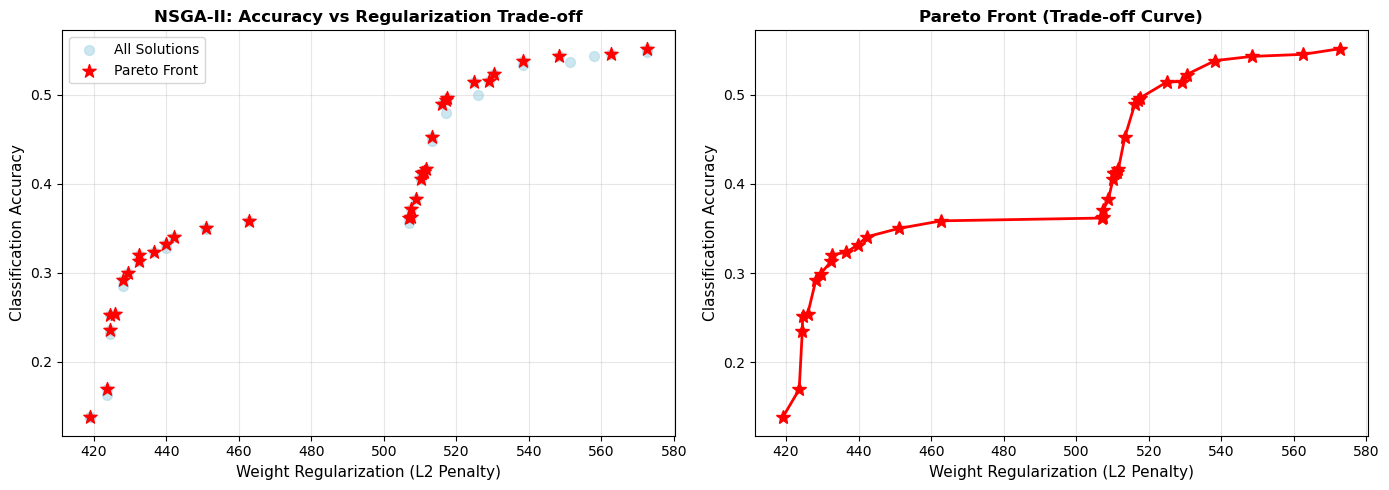


PARETO FRONT ANALYSIS

Solution with highest accuracy:
  Accuracy: 0.5516
  Regularization: 572.6073

Solution with lowest regularization:
  Accuracy: 0.1383
  Regularization: 419.0758



In [ ]:
# VISUALIZE PARETO FRONT


# Extract objectives from all solutions
all_accuracies = [ind.fitness.values[0] for ind in population]
all_regularizations = [ind.fitness.values[1] for ind in population]

# Extract Pareto front
pareto_accuracies = [ind.fitness.values[0] for ind in pareto_front]
pareto_regularizations = [ind.fitness.values[1] for ind in pareto_front]

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: All solutions with Pareto front highlighted
ax1.scatter(all_regularizations, all_accuracies,
           c='lightblue', alpha=0.6, s=50, label='All Solutions')
ax1.scatter(pareto_regularizations, pareto_accuracies,
           c='red', s=100, marker='*', label='Pareto Front', zorder=5)
ax1.set_xlabel('Weight Regularization (L2 Penalty)', fontsize=11)
ax1.set_ylabel('Classification Accuracy', fontsize=11)
ax1.set_title('NSGA-II: Accuracy vs Regularization Trade-off',
             fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Pareto front only (zoomed in)
# Sort by regularization for better visualization
sorted_indices = np.argsort(pareto_regularizations)
sorted_reg = [pareto_regularizations[i] for i in sorted_indices]
sorted_acc = [pareto_accuracies[i] for i in sorted_indices]

ax2.plot(sorted_reg, sorted_acc, 'r*-', linewidth=2, markersize=10)
ax2.set_xlabel('Weight Regularization (L2 Penalty)', fontsize=11)
ax2.set_ylabel('Classification Accuracy', fontsize=11)
ax2.set_title('Pareto Front (Trade-off Curve)',
             fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find extreme solutions on Pareto front
max_acc_idx = np.argmax(pareto_accuracies)
min_reg_idx = np.argmin(pareto_regularizations)

print("\n" + "="*70)
print("PARETO FRONT ANALYSIS")
print("="*70)
print(f"\nSolution with highest accuracy:")
print(f"  Accuracy: {pareto_accuracies[max_acc_idx]:.4f}")
print(f"  Regularization: {pareto_regularizations[max_acc_idx]:.4f}")
print(f"\nSolution with lowest regularization:")
print(f"  Accuracy: {pareto_accuracies[min_reg_idx]:.4f}")
print(f"  Regularization: {pareto_regularizations[min_reg_idx]:.4f}")
print("\n" + "="*70)